In [6]:
import torch
from PIL import Image
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import math
import requests
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from accelerate import Accelerator
import utils
from tqdm import tqdm
import torch.nn.functional as F

In [7]:
training_config = utils.DiffusionTrainingArgs()

In [8]:
# Load an image of my dog for this example

image_url = "https://i.imgur.com/IJcs4Aa.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)

In [9]:
# Define the transforms to apply to the image for training
augmentations = utils.get_train_transforms(training_config)

In [10]:
train_image = augmentations(image.convert("RGB"))

In [11]:
accelerator = Accelerator(
    gradient_accumulation_steps=training_config.gradient_accumulation_steps,
    mixed_precision=training_config.mixed_precision,
)

In [12]:
model = utils.get_unet(training_config)

In [13]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_config.learning_rate,
    betas=(training_config.adam_beta1, training_config.adam_beta2),
    weight_decay=training_config.adam_weight_decay,
    eps=training_config.adam_epsilon,
)

In [14]:
lr_scheduler = get_scheduler(
    training_config.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=training_config.lr_warmup_steps,
    num_training_steps=(training_config.num_epochs) // training_config.gradient_accumulation_steps,
)

In [15]:
model, optimizer, train_image, lr_scheduler = accelerator.prepare(
    model, optimizer, train_image, lr_scheduler
)

In [16]:
num_update_steps_per_epoch = math.ceil(training_config.batch_size / training_config.gradient_accumulation_steps)

In [17]:
ema_model = EMAModel(model, inv_gamma=training_config.ema_inv_gamma, power=training_config.ema_power, max_value=training_config.ema_max_decay)


In [18]:
if accelerator.is_main_process:
    run = "train.py"
    accelerator.init_trackers(run)

In [19]:
global_step = 0
for epoch in range(training_config.num_epochs):
    model.train()
    progress_bar = tqdm(total=num_update_steps_per_epoch, disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    batch = train_image.unsqueeze(0).repeat(
        16, 1, 1, 1
    ).to(accelerator.device)
    noise = torch.randn(batch.shape).to(accelerator.device)
    bsz = batch.shape[0]
    # Sample a random timestep for each image
    timesteps = torch.randint(
        0, noise_scheduler.config.num_train_timesteps, (bsz,), device=batch.device
    ).long()
    noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
    with accelerator.accumulate(model):
        # Predict the noise residual
        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)
        accelerator.backward(loss)

        if accelerator.sync_gradients:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        if training_config.use_ema:
            ema_model.step(model)
        optimizer.zero_grad()

    # Checks if the accelerator has performed an optimization step behind the scenes
    if accelerator.sync_gradients:
        progress_bar.update(1)
        global_step += 1

    logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
    if training_config.use_ema:
        logs["ema_decay"] = ema_model.decay
    progress_bar.set_postfix(**logs)
    accelerator.log(logs, step=global_step)
    progress_bar.close()

    accelerator.wait_for_everyone()

Epoch 499:   6%|▋         | 1/16 [00:00<00:03,  4.74it/s, ema_decay=0.991, loss=0.0567, lr=0.0001, step=500]


In [20]:
pipeline = DDPMPipeline(
    unet=accelerator.unwrap_model(ema_model.averaged_model if training_config.use_ema else model),
    scheduler=noise_scheduler,
)

generator = torch.manual_seed(0)
# run pipeline in inference (sample random noise and denoise)
images = pipeline(generator=generator, batch_size=training_config.batch_size, output_type="numpy").images

# denormalize the images and save to tensorboard
images_processed = (images * 255).round().astype("uint8")

  0%|          | 0/1000 [00:00<?, ?it/s]

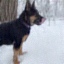

In [21]:
display(Image.fromarray(images_processed[0]))

In [23]:
import json
json.dump(model.config, open("teacher_config.json", "w"))

In [24]:
torch.save(model.state_dict(), "minnie-diffusion/diffusion_pytorch_model.bin")